Found 5144 files belonging to 3 classes.
Found 1288 files belonging to 3 classes.
Class labels: ['COVID19', 'NORMAL', 'PNEUMONIA']


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.5688 - loss: 1.1602 - val_accuracy: 0.8455 - val_loss: 0.4148
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.7511 - loss: 0.6243 - val_accuracy: 0.9099 - val_loss: 0.2616
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 745s 5s/step - accuracy: 0.8225 - loss: 0.4443 - val_accuracy: 0.9224 - val_loss: 0.2169
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 2151s 13s/step - accuracy: 0.8621 - loss: 0.3442 - val_accuracy: 0.9286 - val_loss: 0.1917
Epoch 5/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.8646 - loss: 0.3316 - val_accuracy: 0.9309 - val_loss: 0.1795
41/41 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9185 - loss: 0.1954
✅ Test Accuracy: 93.09%
41/41 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step

Confusion Matrix:
 [[ 11  36  69]
 [ 19  84 214]
 [ 69 209 577]]


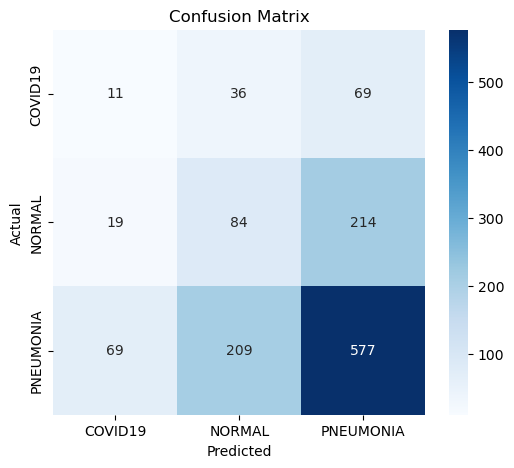


Classification Report:
              precision    recall  f1-score   support

     COVID19       0.11      0.09      0.10       116
      NORMAL       0.26      0.26      0.26       317
   PNEUMONIA       0.67      0.67      0.67       855

    accuracy                           0.52      1288
   macro avg       0.35      0.34      0.35      1288
weighted avg       0.52      0.52      0.52      1288



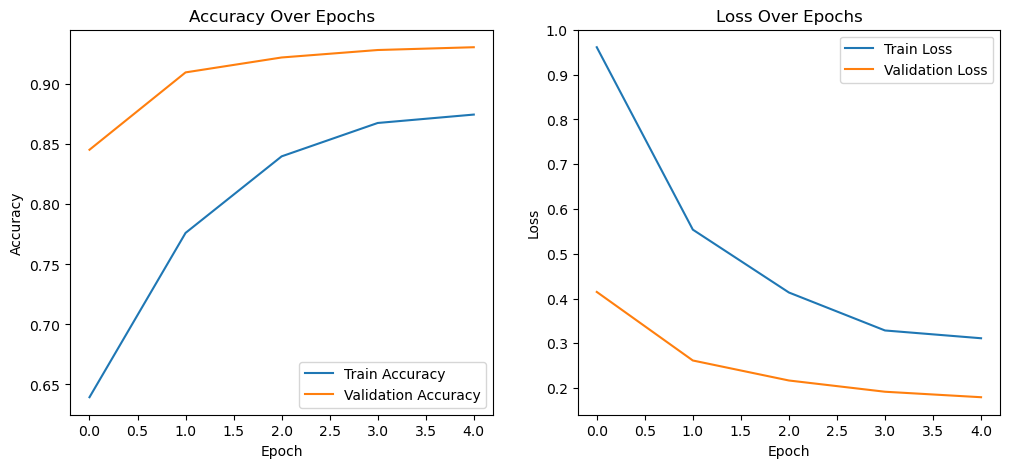

✅ Model saved successfully as 'covid_pneumonia_resnet50_fixed.keras'


In [1]:


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os


train_dir = "Data/train"
test_dir = "Data/test"

img_size = (224, 224)
batch_size = 32

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Class labels:", class_names)


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)


test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")


y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


model.save("covid_pneumonia_resnet50_fixed.keras")
print("✅ Model saved successfully as 'covid_pneumonia_resnet50_fixed.keras'")

